<a href="https://colab.research.google.com/github/vypr213/preclinical/blob/master/Train_Clinical_031820.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!ln -s /content/drive/My\ Drive/Data /content/Data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Setup Data

In [2]:
import os

try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

def plot_img_with_label(image, label, pred_lbl=None):
  # In order to only show non-zero component of label,
  # set zero component to NAN
  label = np.ma.masked_where(label == 0, label)


  fig, (ax1, ax2) = plt.subplots(ncols=2, dpi=100)
  _ = ax1.imshow(image, cmap='gray')
  _ = ax1.imshow(label, cmap='jet')
  _ = ax1.set_title("Original Label")
  _ = ax1.axis("off")

  _ = ax2.imshow(image, cmap='gray')

  if (pred_lbl is not None):
    pred_lbl = np.ma.masked_where(pred_lbl == 0, label)

    _ = ax2.imshow(pred_lbl, cmap='jet')
    _ = ax2.set_title("Predicted Label")
  else:
    _ = ax2.set_title("Base image without label")

  _ = ax2.axis("off")

def plot_batch(batch):
  assert(len(batch) == 2)

  images = tf.cast(batch[0], tf.uint16)
  labels = tf.cast(batch[1], tf.uint16)

  images = images.numpy()
  labels = labels.numpy()

  assert(images.shape == labels.shape)

  shp = images.shape

  for i in range(shp[0]):
    img = images[i, :, :, 0]
    lbl = labels[i, :, :, 0]
    plot_img_with_label(img, lbl)

def plot_dataset_with_predictions(dataset, predictions):
  index = 0

  for batch in dataset:
    assert(len(batch) == 2)
  
    images = tf.cast(batch[0], tf.uint16)
    labels = tf.cast(batch[1], tf.uint16)
  
    images = images.numpy()
    labels = labels.numpy()
  
    assert(images.shape == labels.shape)
    assert(images.shape[3] == 1)
  
    shp = images.shape
  
    for i in range(shp[0]):
      img = images[i, :, :, 0]
      lbl = labels[i, :, :, 0]

      pred = predictions[index]
      assert(pred.shape[2] == 1)
      pred = pred.reshape((pred.shape[0], pred.shape[1]))

      plot_img_with_label(img, lbl, pred_lbl=pred)

      index += 1

def panic_if_not_exists(path):
  if not os.path.exists(path):
    raise Exception("Path does not exist: [" + path + "]")

def get_TFR_list(base_dir):
  tfr_files = []

  if (not os.path.exists(base_dir)):
    raise Exception("[ERROR]: " + base_dir + " does not exist.")
   
  for f in os.listdir(os.path.abspath(base_dir)):
    # f, _ = os.path.splitext(base_dir)
    # print(os.path.abspath(base_dir) + "/" + f)
    tfr_files.append(os.path.abspath(base_dir) + "/" + f)

  return tfr_files

def save_datasets(save_dir,
                  train_set,
                  dev_set,
                  test_set,
                  is_2D=True
                 ):
  panic_if_not_exists(save_dir)

  save_dir = os.path.abspath(save_dir)

  if is_2D:
    train_F = os.path.join(save_dir, "train_set_2D.txt")
    dev_F   = os.path.join(save_dir,   "dev_set_2D.txt")
    test_F  = os.path.join(save_dir,  "test_set_2D.txt")
  else:
    train_F = os.path.join(save_dir, "train_set.txt")
    dev_F   = os.path.join(save_dir,   "dev_set.txt")
    test_F  = os.path.join(save_dir,  "test_set.txt")

  with open(train_F, "w") as f:
    for train_id in train_set:
      f.write(train_id + "\n")

  with open(dev_F, "w") as f:
    for dev_id in dev_set:
      f.write(dev_id + "\n")

  with open(test_F, "w") as f:
    for test_id in test_set:
      f.write(test_id + "\n")

  panic_if_not_exists(train_F)
  panic_if_not_exists(dev_F)
  panic_if_not_exists(test_F)

# Let's split the 1811 examples as follows
# Train set - 1600
# Dev   set -  111
# Test  set -  100
def setup_dataset_splits(data_dir,
                    train_set_size = 1600,
                    dev_set_size   = 111,
                    test_set_size  = 100,
                    is_2D=True
                   ):
  if (not os.path.exists(data_dir)):
    raise Exception("[ERROR]: " + data_dir + " does not exist.")

  train_set_IDs = []
  dev_set_IDs   = []
  test_set_IDs  = []

  for f in os.listdir(os.path.abspath(data_dir)):
    #f, _ = os.path.splitext(data_dir)
    train_set_IDs.append(f)

  assert(len(train_set_IDs) == 1811)

  # Now, carve out the dev set out of train_set
  #
  # We will hold out
  #   - 111 (a little higher than ~5%) of 1811 examples for dev set
  #   - 100 (a little higher than ~5%) of 1811 examples for test set
  #
  # All these scans are randomly selected

  # For consistency, let's setup a seed
  random.seed(10)

  for i in range(dev_set_size):
    rand_ind = random.randint(0, (len(train_set_IDs) - 1))
    dev_set_IDs.append(train_set_IDs[rand_ind])
    train_set_IDs.pop(rand_ind)

  for i in range(test_set_size):
    rand_ind = random.randint(0, (len(train_set_IDs) - 1))
    test_set_IDs.append(train_set_IDs[rand_ind])
    train_set_IDs.pop(rand_ind)

  random.shuffle(train_set_IDs)

  assert(len(train_set_IDs) == 1600)
  assert(len(dev_set_IDs) == 111)
  assert(len(test_set_IDs) == 100)

  datasets = {
      'train' : train_set_IDs,
      'dev'   : dev_set_IDs,
      'test'  : test_set_IDs
  }

  save_datasets(data_dir,
                datasets["train"],
                datasets["dev"],
                datasets["test"],
                is_2D=True
               )

  return datasets

# Load the example ids for train/dev/test sets
def load_datasets_ids(data_dir, is_2D=True):
  panic_if_not_exists(data_dir)

  data_dir = os.path.abspath(data_dir)

  if is_2D:
    train_F = os.path.join(data_dir, "train_set_2D.txt")
    dev_F   = os.path.join(data_dir,   "dev_set_2D.txt")
    test_F  = os.path.join(data_dir,  "test_set_2D.txt")
  else:
    train_F = os.path.join(data_dir, "train_set.txt")
    dev_F   = os.path.join(data_dir,   "dev_set.txt")
    test_F  = os.path.join(data_dir,  "test_set.txt")

  train_X = []
  dev_X   = []
  test_X  = []

  if not (    os.path.exists(train_F)
          or os.path.exists(dev_F)
          or os.path.exists(test_F)):

    print("[INFO]: Cannot find existing datasets - Creating new ones")
    return setup_dataset_splits(data_dir, is_2D=is_2D)

  print("[INFO]: Reading in existing datasets")
  # Else, read in the saved ids
  with open(train_F, "r") as f:
    train_X = [line.rstrip("\n") for line in f]
  assert train_X, "train_X is empty"

  with open(dev_F, "r") as f:
    dev_X = [line.rstrip("\n") for line in f]
  assert dev_X, "dev_X is empty"

  with open(test_F, "r") as f:
    test_X = [line.rstrip("\n") for line in f]
  assert test_X, "test_X is empty"


  return { "train" : train_X,
           "dev"   : dev_X,
           "test"  : test_X
         }

def convert_IDs_to_Paths(data_dir,
                         train_set,
                         dev_set,
                         test_set
                        ):
  panic_if_not_exists(data_dir)

  train_X = []
  dev_X   = []
  test_X  = []

  for example_id in train_set:
    example_F = data_dir + "/" + example_id
    panic_if_not_exists(example_F)

    train_X.append(example_F)

  for example_id in dev_set:
    example_F = data_dir + "/" + example_id
    panic_if_not_exists(example_F)

    dev_X.append(example_F)

  for example_id in test_set:
    example_F = data_dir + "/" + example_id
    panic_if_not_exists(example_F)

    test_X.append(example_F)

  return { "train" : train_X,
            "dev"   : dev_X,
            "test"  : test_X
         }

def b_contains_elements_of_a(a, b):
  for item in a:
    if item in b:
      raise Exception("Element {} in list 1 also exists in list 2".format(item))

def lists_have_common_elements(a, b):
  return b_contains_elements_of_a(a, b) or b_contains_elements_of_a(b, a)

def validate_datasets(train_set,
                      dev_set,
                      test_set):

  lists_have_common_elements(train_set, dev_set)                      
  lists_have_common_elements(train_set, test_set)                      
  lists_have_common_elements(dev_set,   test_set)                      

  print("[SUCCESS]: Datasets are valid")

def get_train_dev_test_lists(data_dir, is_2D=True):
  dataset_ids   = load_datasets_ids(data_dir)
  dataset_paths = convert_IDs_to_Paths(data_dir,
                                       dataset_ids["train"],
                                       dataset_ids["dev"],
                                       dataset_ids["test"]
                                      ) 

  validate_datasets(dataset_paths["train"],
                    dataset_paths["dev"],
                    dataset_paths["test"]
                   )

  return dataset_paths["train"], dataset_paths["dev"], dataset_paths["test"]

def parse_single_TFRecord(raw_record):
  
  data_feature_description = {
    "height"     : tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
    "width"      : tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
    "image"      : tf.io.FixedLenFeature(shape=(), dtype=tf.string),
    "lab_indices": tf.io.FixedLenFeature(shape=(), dtype=tf.string),
    "lab_values" : tf.io.FixedLenFeature(shape=(), dtype=tf.string),
    "lab_n_vals" : tf.io.FixedLenFeature(shape=(), dtype=tf.int64),
  }

  example = tf.io.parse_single_example(raw_record,
                                       data_feature_description)
  height = example["height"]
  width  = example["width"]

  image = tf.io.decode_raw(example["image"], tf.uint16)
  image = tf.reshape(image, (height, width, 1))
  image = tf.cast(image, tf.float16)
  
  indices = tf.io.decode_raw(example["lab_indices"], tf.int64)
  values  = tf.io.decode_raw(example["lab_values"], tf.uint16)

  indices = tf.reshape(indices, (example["lab_n_vals"], 2))
  
  label_sparse = tf.sparse.SparseTensor(indices,
                                        values,
                                        dense_shape=(height, width))
  label = tf.sparse.to_dense(label_sparse, default_value=0)
  label = tf.reshape(label, (height, width, 1))
  label = tf.cast(label, tf.float16)

  return image, label

def create_dataset(tfr_files, parsing_func, batch_size):
  dataset = tf.data.TFRecordDataset(tfr_files)
  dataset = dataset.map(parsing_func)
  dataset = dataset.batch(batch_size=batch_size)

  return dataset

TensorFlow 2.x selected.
2.1.0


# Test Data Parsing

In [3]:
tfr_files = get_TFR_list("/content/Data/TFR_Data")
print(tfr_files[20:25])

['/content/Data/TFR_Data/1470_20132_00003.tfr', '/content/Data/TFR_Data/1332_18469_00006.tfr', '/content/Data/TFR_Data/1458_20039_00007.tfr', '/content/Data/TFR_Data/1563_21828_00005.tfr', '/content/Data/TFR_Data/1382_19214_00004.tfr']


Batch type.        : <class 'tuple'>
Num items in batch : 2
Type of batch[0]   : <class 'tensorflow.python.framework.ops.EagerTensor'>
Shape of batch[0]  : (2, 256, 256, 1)
Type of batch[1]   : <class 'tensorflow.python.framework.ops.EagerTensor'>
Shape of batch[1]  : (2, 256, 256, 1)




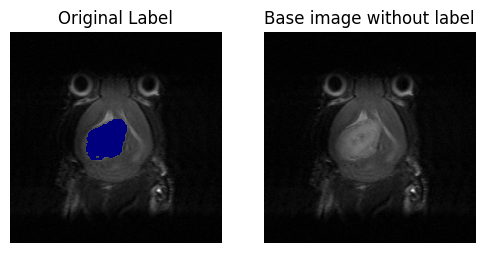

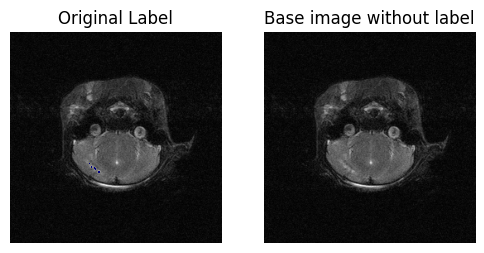

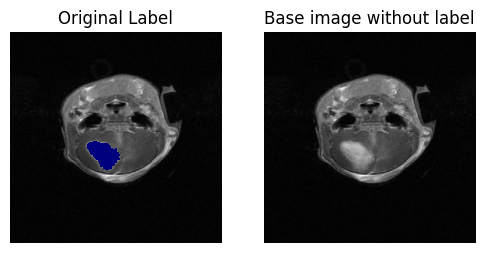

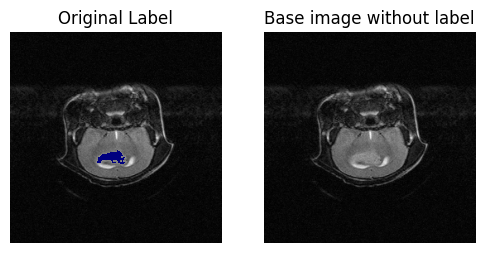

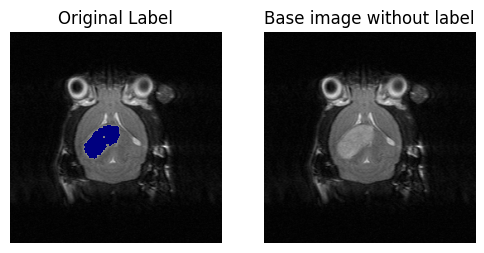

In [4]:
dataset = create_dataset(tfr_files[20:25], parse_single_TFRecord, 2)

for batch in dataset.take(1):
  print("Batch type.        :", type(batch))
  print("Num items in batch :", len(batch))
  print("Type of batch[0]   :", type(batch[0]))
  print("Shape of batch[0]  :", batch[0].shape)
  print("Type of batch[1]   :", type(batch[1]))
  print("Shape of batch[1]  :", batch[1].shape)

print("")
print("==================================================")
print("")

for batch in dataset:
  plot_batch(batch)

/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


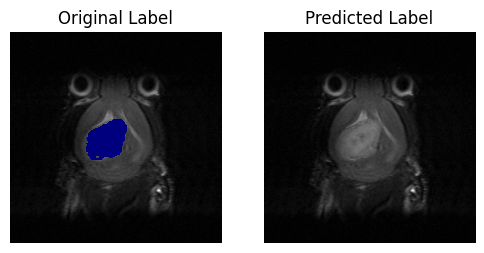

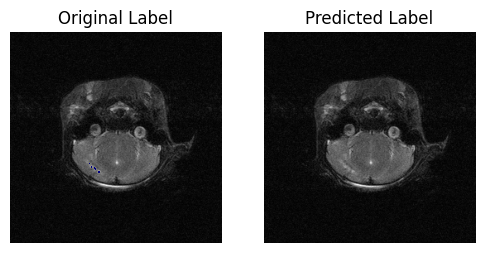

In [5]:
dataset = create_dataset(tfr_files[20:25], parse_single_TFRecord, 2)
dataset = dataset.take(1)

pred_np = np.zeros((256, 256, 1))
pred_np2 = np.zeros((256, 256, 1))
predictions = [pred_np, pred_np2]

plot_dataset_with_predictions(dataset, predictions)

# for batch in dataset.take(1):
#   print("Batch type.        :", type(batch))
#   print("Num items in batch :", len(batch))
#   print("Type of batch[0]   :", type(batch[0]))
#   print("Shape of batch[0]  :", batch[0].shape)
#   print("Type of batch[1]   :", type(batch[1]))
#   print("Shape of batch[1]  :", batch[1].shape)

# print("")
# print("==================================================")
# print("")

# for batch in dataset:
#   plot_batch(batch)

# Define Model

In [0]:
try:
  # Only works in Google Colab
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
from   tensorflow.keras.layers import Conv2D, MaxPool2D, Conv2DTranspose
from   tensorflow.keras.layers import Activation, BatchNormalization, Dropout
from   tensorflow.keras.regularizers import l2

class Unet2D():
  CHANNEL_FIRST_AXIS = 1
  CHANNEL_LAST_AXIS  = -1

  def __init__(self,
               input_shape,
               batch_size = 50,
               num_levels = 4,
               batch_norm = False,
               drop_prob  = 0,
               lambada    = 0,
               activation = None,
               data_format = "channels_last",
               is_training = True):
    
    self.input_shape = input_shape

    self.batch_size  = batch_size
    self.num_levels  = num_levels
    self.batch_norm  = batch_norm
    self.drop_prob   = drop_prob
    self.lambada     = lambada


    self.activation  = activation
    self.data_format = data_format
    self.is_training = is_training

    if (self.data_format == "channel_first"):
      self.concat_axis = self.CHANNEL_FIRST_AXIS
    else:
      self.concat_axis = self.CHANNEL_LAST_AXIS

    self.model = self.unet2D_model()
  
  def get_model(self):
    return self.model

  # Convinience wrapper for Keras Conv2D
  def __conv2D(self,
               inputT,
               num_filters,
               filter_shape=(3, 3),
               padding="same",
               stride=(1, 1)
              ):
      if self.lambada != 0:
          weight_reg = l2(self.lambada)
          bias_reg   = l2(self.lambada)
          gamma_reg  = l2(self.lambada)
          beta_reg   = l2(self.lambada)
      else:
          weight_reg = None
          bias_reg   = None
          gamma_reg  = None
          beta_reg   = None

      z = Conv2D(filters            = num_filters,
                 kernel_size        = filter_shape,
                 strides            = stride,
                 padding            = padding,
                 data_format        = self.data_format,
                 kernel_regularizer = weight_reg,
                 bias_regularizer   = bias_reg)(inputT)

                 # kernel_initializer   = xavier_initializer(seed = 1),
                 # bias_initializer     = tf.zeros_initializer(),
                 # input_shape          = inputT.shape)(inputT)


      # TODO: Apply Batch normalization
      if self.batch_norm == True:
          # z = BatchNormalization(axis = 1, momentum=0.78)(z)
          z = BatchNormalization(axis              = 1,
                                 beta_regularizer  = beta_reg,
                                 gamma_regularizer = gamma_reg)(z)

      a = Activation('relu')(z)

      # if self.drop_prob != 0:
      #     a = Dropout(self.drop_prob)(a)

      return a

  #
  # Down-Convolution block
  # '
  # '--> Two 3x3 convolutions with RelU
  # '
  # '--> 2x2 MaxPool with stride 2
  #
  def down_block(self,
                 inputT,
                 num_filters,
                 name,
                 filter_shape=(3, 3),
                 padding="same",
                 stride=1
                ):

    a = self.__conv2D(inputT, num_filters, filter_shape, padding, stride)

    # As per Cicek et.al.
    # 3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation
    #
    # doubling the number of filters before max-pooling
    # a = self.__conv2D(a, num_filters*2, filter_shape, padding, stride)

    # Looks like we are getting high variance if we double the filters
    a = self.__conv2D(a, num_filters, filter_shape, padding, stride)

    # Apply a 2x2x2, stride 2 Max Pooling
    m = MaxPool2D(pool_size   = (2, 2),
                  # strides   = (2, 2), # Default to pool_size
                  data_format = self.data_format)(a)

    # if self.drop_prob != 0:
    #     m = Dropout(rate = self.drop_prob)(m)

    return a, m

  #
  # Up-Convolution block
  # '
  # '--> 2x2 Up-sampling
  # '
  # '--> Concatenation with corresponding activations from down-conv layer
  # '
  # '--> Two 3x3 convolutions + RelU
  #
  def up_block(self,
               inputT,
               skip_connection,
               num_filters,
               name,
               filter_shape=(3, 3),
               padding="same",
               stride=1
              ):

    if self.lambada != 0:
        weight_reg = l2(self.lambada)
        bias_reg   = l2(self.lambada)
    else:
        weight_reg = None
        bias_reg   = None

    # up_sampled = UpSampling2D(size=(2, 2),
    #                           data_format=self.data_format)(inputT)
    up_sampled = Conv2DTranspose(filters            = num_filters,
                                 kernel_size        = (2, 2),
                                 strides            = (2, 2),
                                 padding            = "same",
                                 data_format        = self.data_format,
                                 kernel_regularizer = weight_reg,
                                 bias_regularizer   = bias_reg)(inputT)

    concat_input = tf.keras.layers.concatenate([up_sampled, skip_connection],
                                               axis=self.concat_axis)

    # Now, apply two 3x3 conv + RelU
    a1 = self.__conv2D(concat_input, num_filters, filter_shape,
                       padding, stride)
    
    a2 = self.__conv2D(a1, num_filters, filter_shape, padding, stride)

    # if self.drop_prob != 0:
    #     a2 = Dropout(rate = self.drop_prob)(a2)

    return a2

  #
  # Bottom-most layer of U-Net
  # '
  # '--> Connects down-block and up-block
  #
  # Comprises of two 3x3 convolutions with RelU activations
  #
  def connector_block(self,
                      inputT,
                      num_filters,
                      name,
                      filter_shape=(3, 3),
                      padding="same",
                      stride=1
                     ):

    a1 = self.__conv2D(inputT, num_filters, filter_shape, padding, stride)
    a2 = self.__conv2D(a1,     num_filters, filter_shape, padding, stride)

    if self.drop_prob != 0:
        a2 = Dropout(rate = self.drop_prob)(a2)

    return a2

  # Parameterized, model
  def unet2D_model(self):
    print(str(self.input_shape) + " Input")

    if self.batch_norm == True:
      print("[INFO]: Using Batch norm")

    if self.drop_prob != 0:
      print("[INFO]: Using Dropout with drop_prob " + str(self.drop_prob))

    if self.lambada != 0:
      print("[INFO]: Using L2 regularization with lambda =  " + str(self.lambada))
      weight_reg = l2(self.lambada)
      bias_reg   = l2(self.lambada)
    else:
      weight_reg = None
      bias_reg   = None


    X = tf.keras.layers.Input(shape      = self.input_shape,
                              batch_size = self.batch_size,
                              name       = "input_X"
                             )

    down_conv_activations = []

    # Setup num filters for each level
    num_filters = []
    filters = 8
    for level in range(self.num_levels + 1):
      num_filters.append(filters)
      filters = filters * 2

    #
    # a_n --> Activation of the layer before applying maxPool
    #     '
    #     '--> Need these for skip connections
    #
    # m_n --> Output from MaxPool
    #     '
    #     '--> These become inputs to next layer
    #
    m_n = X

    for level in range(self.num_levels):
      a_n, m_n = self.down_block(m_n,
                                 num_filters[level],
                                 name="d" + str(level))

      # Save down-conv activations for skip connections in up-convs
      down_conv_activations.append(a_n)


    # Add the bottom connection (tangential) layer
    t = self.connector_block(m_n,
                             num_filters[self.num_levels],
                             name="t1")

    # Now, upconvert
    input_features = t
    for level in reversed(range(self.num_levels)):
      input_features = self.up_block(input_features,
                                     down_conv_activations[level],
                                     num_filters[level],
                                     name="up" + str(level))

    # Final layer
    # '
    # '--> 1x1 convolution to make output match
    y_hat = Conv2D(filters            = 1,
                   kernel_size        = (1, 1),
                   # padding          = "same",
                   # strides          = 1,
                   data_format        = self.data_format,
                   kernel_regularizer = weight_reg,
                   bias_regularizer   = bias_reg,
                   name               = "final")(input_features)

                   # kernel_initializer = xavier_initializer(seed = 1),
                   # bias_initializer   = tf.zeros_initializer(),
                   # activation         = tf.nn.sigmoid,

    if (not self.activation is None):
      y_hat = Activation(self.activation)(y_hat)
    
    model = tf.keras.models.Model(inputs=X, outputs=y_hat)

    return model

# Loss Functions

In [0]:
import tensorflow.keras.backend as K

# Dice function based on Milletari's V-Net paper
def dice_coef(Y, Y_hat):
  smooth = 1.

  flat_Y       = K.flatten(Y)
  flat_Y_hat   = K.flatten(Y_hat)

  intersection = K.sum(flat_Y * flat_Y_hat)
  return (2. * intersection + smooth) / (K.sum(flat_Y) + K.sum(flat_Y_hat) + smooth)

def dice_loss(y_true, y_pred):
  return -dice_coef(y_true, y_pred)

# Setup the Model

## Imports

In [8]:
try:
  # Only works in Google Colab
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
print(tf.__version__)

2.1.0


## [STEP 1]: Define a model

In [0]:
def define_model(data_params, hyper_params):
  height = data_params["height"]
  width  = data_params["width"]
  n_channels = data_params["n_channels"]
  
  model = Unet2D(input_shape=(height, width, n_channels),
                batch_size = data_params["batch_size"],
                num_levels = hyper_params['num_levels'],
                batch_norm = hyper_params['batch_norm'],
                drop_prob  = hyper_params['drop_prob'],
                lambada    = hyper_params['lambda'],
                activation = 'sigmoid',
                is_training = True
                ).get_model()

  return model

## [STEP 2]: Configure the Model

In [0]:
def config_n_compile_model(model, learning_rate):
  optimizer_algo = tf.keras.optimizers.Adam(learning_rate = learning_rate)
  loss_func      = dice_loss
  model_metrics  = ["mse", dice_coef]
  
  model.compile(optimizer = optimizer_algo,
                loss      = loss_func,
                metrics   = model_metrics
              )

  return model            

## [STEP 3]: Setup Data Pipeline

In [0]:
def get_tf_datasets(data_dir, is_train = True):
  train_list, dev_list, test_list = get_train_dev_test_lists(data_dir)
  
  if is_train:
    train_dataset = create_dataset(tfr_files    = train_list,
                                  parsing_func = parse_single_TFRecord,
                                  batch_size   = data_params["batch_size"]
                                  )
    
    val_dataset = create_dataset(tfr_files    = dev_list,
                                parsing_func = parse_single_TFRecord,
                                batch_size   = data_params["batch_size"]
                                )

    test_dataset = None
  else:
    train_dataset = None
    val_dataset   = None

    test_dataset = create_dataset(tfr_files    = test_list,
                                  parsing_func = parse_single_TFRecord,
                                  batch_size   = data_params["batch_size"]
                                 )

  return train_dataset, val_dataset, test_dataset

## [STEP 4]: Setup callbacks

In [0]:
def load_latest_checkpoint(model, chk_pnt_dir):
  panic_if_not_exists(chk_pnt_dir)

  latest_checkpoint = tf.train.latest_checkpoint(chk_pnt_dir)
  if (latest_checkpoint is not None):
    print("[INFO]: Loading weights from " + latest_checkpoint)
    model.load_weights(latest_checkpoint)

  return model

def get_callbacks(save_dir, cb_params):
  panic_if_not_exists(save_dir)

  chk_pnt_dir = os.path.join(os.path.abspath(save_dir),
                             "checkpoints")
  if not os.path.exists(chk_pnt_dir):
    os.makedirs(chk_pnt_dir)

  chk_pnt_filename = os.path.join(chk_pnt_dir,
                                  "weights_{epoch:03d}"
                                # "weights_{epoch:03d}_{val_loss:.2f}"
                                 )

  my_callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath = chk_pnt_filename,
                                       monitor  = "val_loss",
                                       mode     = "min",
                                       # save_best_only = True,
                                       save_weights_only = True,
                                       save_freq = cb_params["chk_save_freq"],
                                       verbose = 1)

    # tf.keras.callbacks.EarlyStopping(monitor   = "val_loss",
    #                                  mode      = "min",
    #                                  min_delta = cb_params["estop_min_delta"],
    #                                  patience  = cb_params["estop_patience"])
  ]

  cb_dirs = {
      "chk_pnt_dir" : chk_pnt_dir
  }

  return my_callbacks, cb_dirs

## [STEP 5]: Train the Model

In [0]:
def train_model(data_dir,
                save_dir,
                data_params,
                hyper_params,
                cb_params,
                load_weights = True):
  # [STEP 1]
  model = define_model(data_params, hyper_params)

  # [STEP 2]
  model = config_n_compile_model(model, hyper_params["learning_rate"])

  # [STEP 3]
  train_dataset, val_dataset, _ = get_tf_datasets(data_dir, is_train = True) 
  assert(train_dataset is not None)
  assert(val_dataset is not None)

  # [STEP 4]
  my_callbacks, cb_dirs = get_callbacks(save_dir, cb_params)

  # [STEP 4.2]: Load weights if any
  if load_weights == True:
    model = load_latest_checkpoint(model, cb_dirs["chk_pnt_dir"])

  # [STEP 5]
  model.fit(x                = train_dataset,
            validation_data  = val_dataset,
            epochs           = hyper_params["epochs"],
            callbacks        = my_callbacks
            # steps_per_epoch  = len(train_list),
            # validation_steps = len(dev_list)
          )

## [STEP 6]: Test the Model

In [0]:
def test_model(data_dir,
               save_dir,
               data_params,
               hyper_params,
               cb_params,
               load_weights = True):
  # [STEP 1]
  model = define_model(data_params, hyper_params)

  # [STEP 2]
  model = config_n_compile_model(model, hyper_params["learning_rate"])

  # [STEP 3]
  _, _, test_dataset = get_tf_datasets(data_dir, is_train = False) 
  assert(test_dataset is not None)

  # TODO: Remove this
  # test_dataset = test_dataset.take(50)

  # [STEP 4]
  my_callbacks, cb_dirs = get_callbacks(save_dir, cb_params)

  # [STEP 4.2]: Load weights if any
  if load_weights == True:
    model = load_latest_checkpoint(model, cb_dirs["chk_pnt_dir"])

  # [STEP 6]
  test_scores = model.evaluate(x = test_dataset, verbose = 2)
  print("Model test scores: ", test_scores)

  predictions = model.predict(x = test_dataset, verbose = 1)

  # Visualize the predictions
  plot_dataset_with_predictions(test_dataset, predictions)




# Define Master Parameters

In [0]:
data_params = {
    "height"     : 256,
    "width"      : 256, 
    "n_channels" : 1,
    "batch_size" : 1
}

hyper_params = {
    "learning_rate" : 1e-5,
    "epochs"        : 150,
    "num_levels"    : 4,
    "batch_norm"    : False,
    "drop_prob"     : 0,
    "lambda"        : 0
}

cb_params = {
    "chk_save_freq"   : 25,
    "estop_min_delta" : 1e-2,
    "estop_patience"  : 5
}

data_dir = "/content/Data/TFR_Data"
save_dir = "/content/Data/archive"

In [0]:
!mkdir /content/Data/archive

#Do Training

## Try 1 - Batch size = 80

In [0]:
data_params = {
    "height"     : 256,
    "width"      : 256, 
    "n_channels" : 1,
    "batch_size" : 80
}

hyper_params = {
    "learning_rate" : 1e-5,
    "epochs"        : 10,
    "num_levels"    : 4,
    "batch_norm"    : False,
    "drop_prob"     : 0,
    "lambda"        : 0
}

cb_params = {
    "chk_save_freq"   : 1600,
    "estop_min_delta" : 1e-2,
    "estop_patience"  : 5
}

data_dir = "/content/Data/TFR_Data"
save_dir = "/content/Data/archive"

train_model(data_dir,
            save_dir,
            data_params,
            hyper_params,
            cb_params,
            load_weights = True)

(256, 256, 1) Input
[INFO]: Reading in existing datasets
[SUCCESS]: Datasets are valid
[INFO]: Loading weights from /content/Data/archive/checkpoints/weights_001
Epoch 1/10
     19/Unknown - 647s 34s/step - loss: -0.4604 - mse: 0.0110 - dice_coef: 0.4604
Epoch 00001: saving model to /content/Data/archive/checkpoints/weights_001
20/20 [==============================] - 790s 39s/step - loss: -0.4632 - mse: 0.0110 - dice_coef: 0.4632


InvalidArgumentError: ignored

## Try 2 - Batch size = 1

In [0]:
data_params = {
    "height"     : 256,
    "width"      : 256, 
    "n_channels" : 1,
    "batch_size" : 1 
}

hyper_params = {
    "learning_rate" : 1e-5,
    "epochs"        : 100,
    "num_levels"    : 4,
    "batch_norm"    : False,
    "drop_prob"     : 0,
    "lambda"        : 0
}

cb_params = {
    "chk_save_freq"   : 25*1600,
    "estop_min_delta" : 1e-2,
    "estop_patience"  : 5
}

data_dir = "/content/Data/TFR_Data"
save_dir = "/content/Data/archive"

train_model(data_dir,
            save_dir,
            data_params,
            hyper_params,
            cb_params,
            load_weights = True)

(256, 256, 1) Input
[INFO]: Reading in existing datasets
[SUCCESS]: Datasets are valid
[INFO]: Loading weights from /content/Data/archive/checkpoints/weights_001
Epoch 1/100
1600/1600 [==============================] - 19s 12ms/step - loss: -0.5161 - mse: 0.0090 - dice_coef: 0.5161 - val_loss: -0.5714 - val_mse: 0.0066 - val_dice_coef: 0.5714
Epoch 2/100
1600/1600 [==============================] - 15s 9ms/step - loss: -0.5914 - mse: 0.0065 - dice_coef: 0.5914 - val_loss: -0.5909 - val_mse: 0.0069 - val_dice_coef: 0.5909
Epoch 3/100
1600/1600 [==============================] - 15s 9ms/step - loss: -0.6160 - mse: 0.0060 - dice_coef: 0.6160 - val_loss: -0.6199 - val_mse: 0.0057 - val_dice_coef: 0.6199
Epoch 4/100
1600/1600 [==============================] - 15s 9ms/step - loss: -0.6315 - mse: 0.0056 - dice_coef: 0.6315 - val_loss: -0.6135 - val_mse: 0.0063 - val_dice_coef: 0.6135
Epoch 5/100
1600/1600 [==============================] - 15s 9ms/step - loss: -0.6429 - mse: 0.0054 - dice_co

# Testing the Model

## Try 1 with model at -0.8097 val_loss

(256, 256, 1) Input
[INFO]: Reading in existing datasets
[SUCCESS]: Datasets are valid
[INFO]: Loading weights from /content/Data/archive/checkpoints/weights_100
Model test scores:  [-0.8314182375371456, 0.002175499, 0.83141816]
    100/Unknown - 1s 11ms/step

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


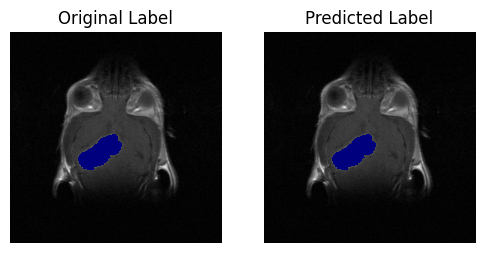

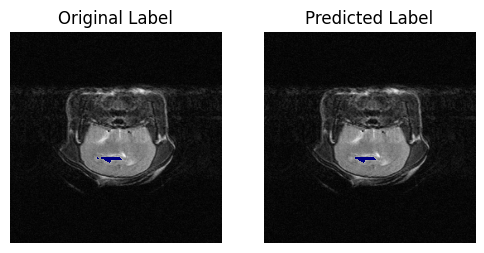

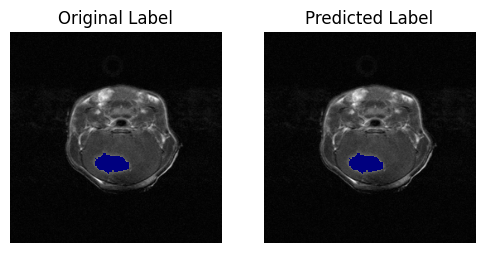

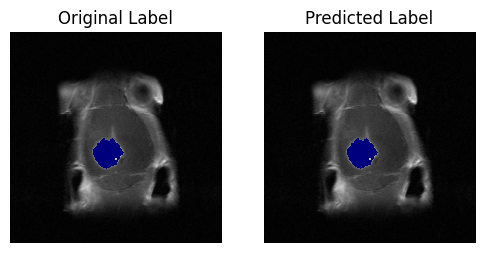

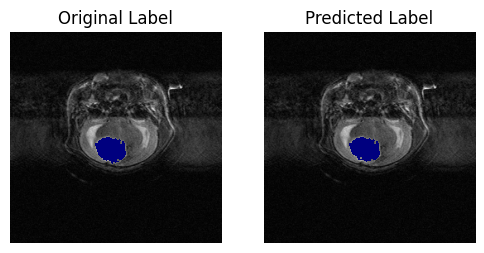

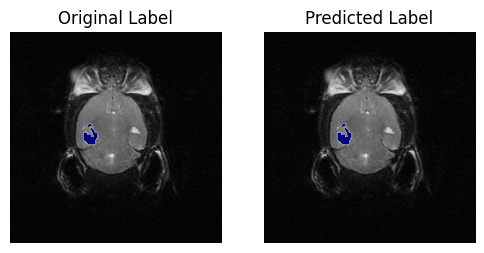

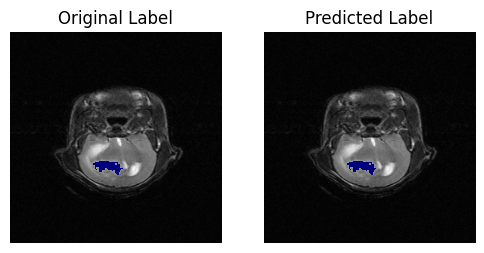

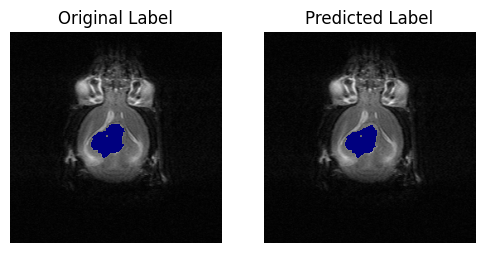

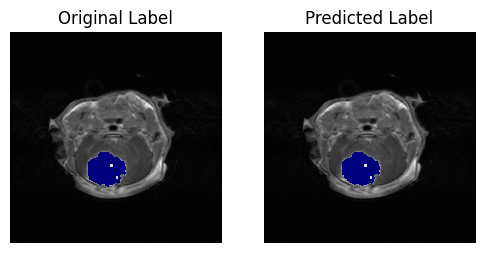

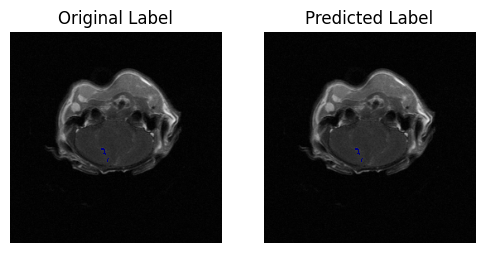

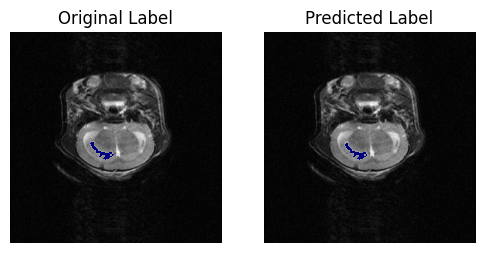

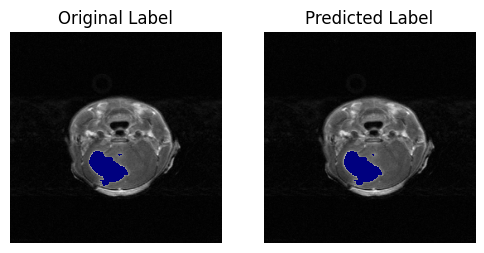

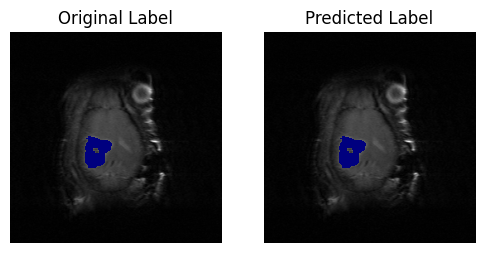

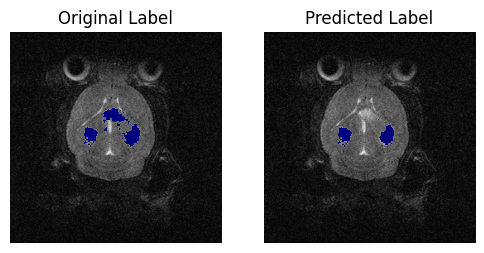

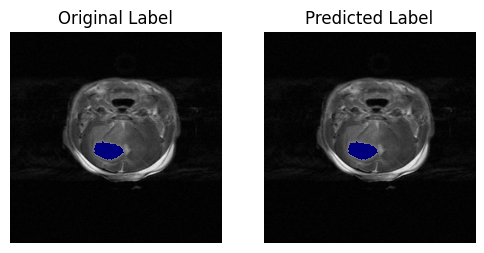

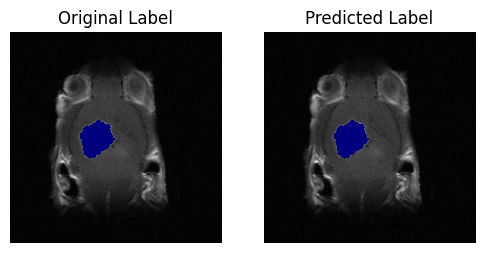

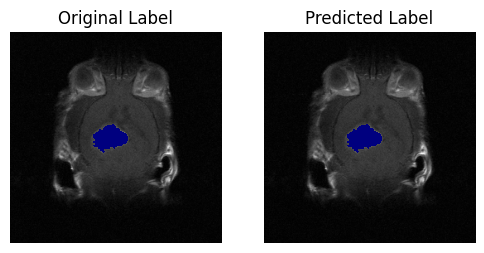

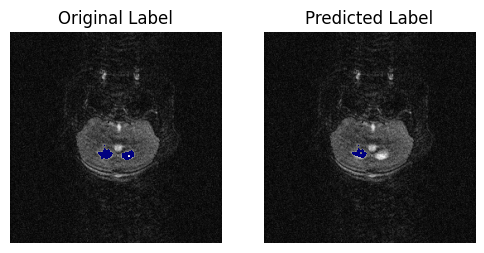

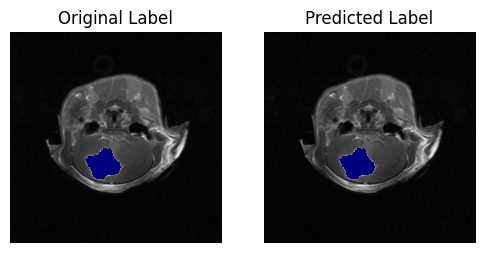

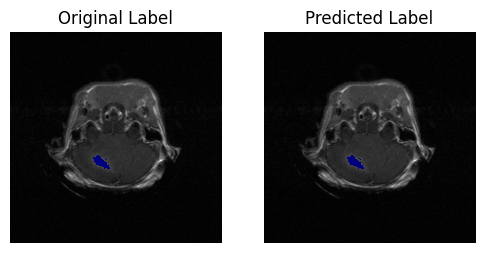

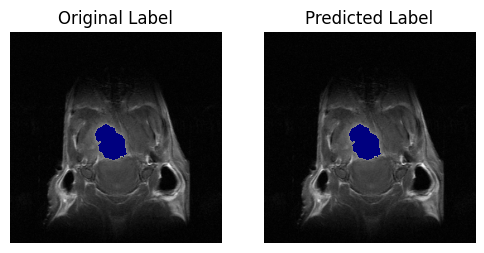

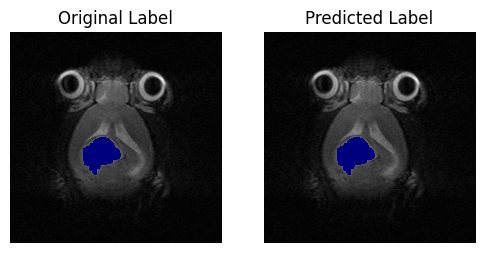

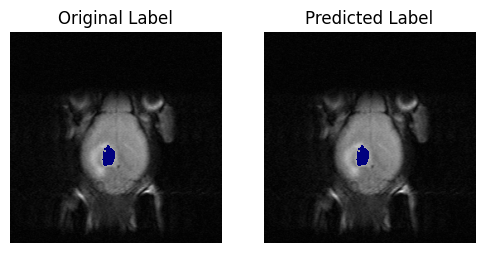

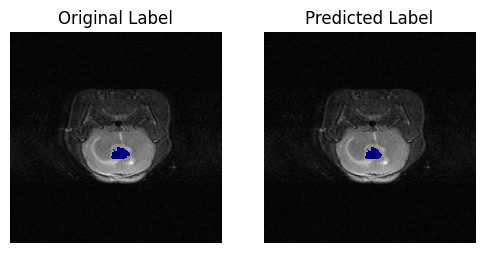

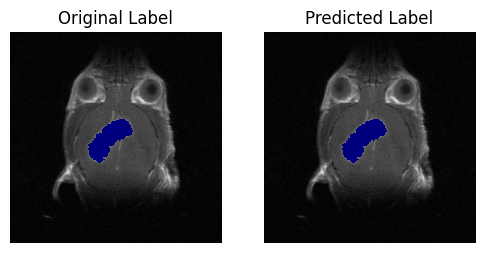

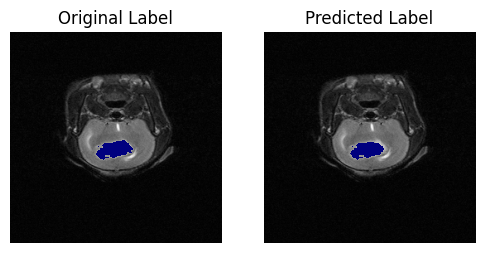

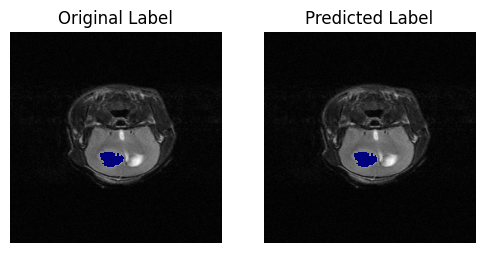

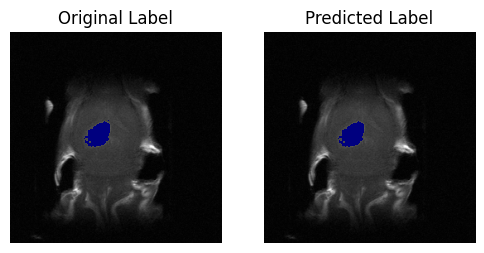

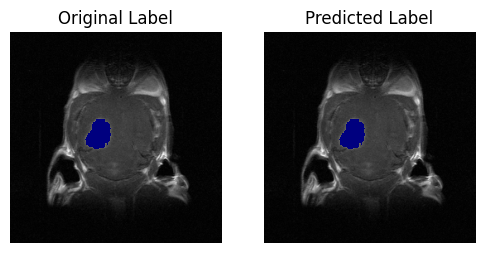

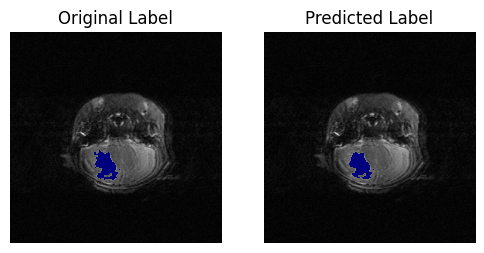

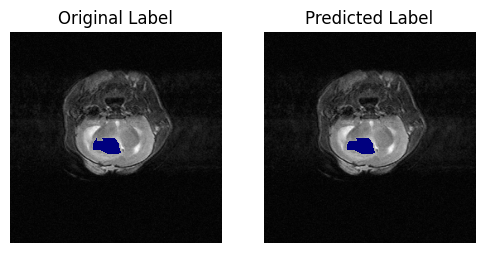

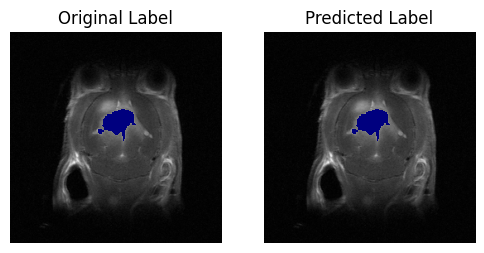

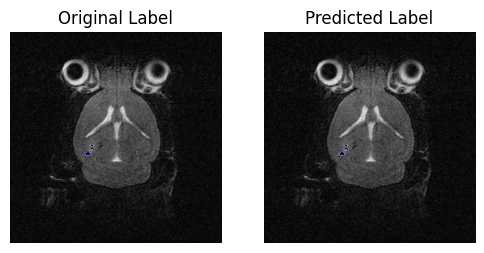

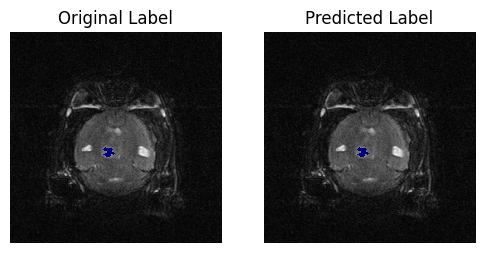

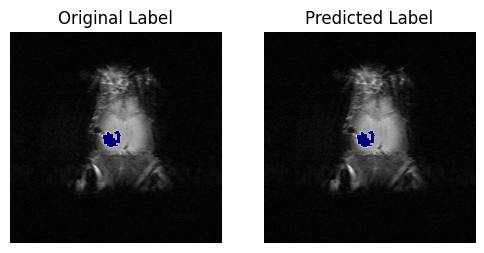

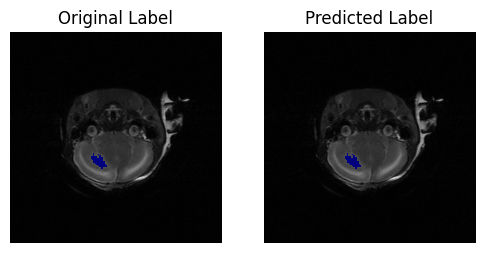

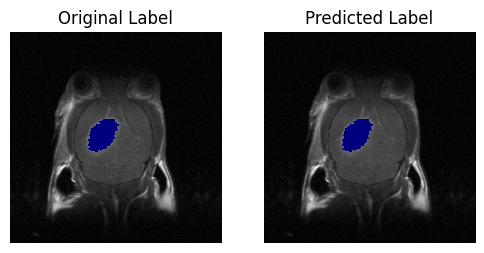

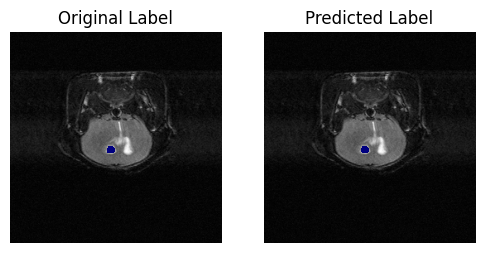

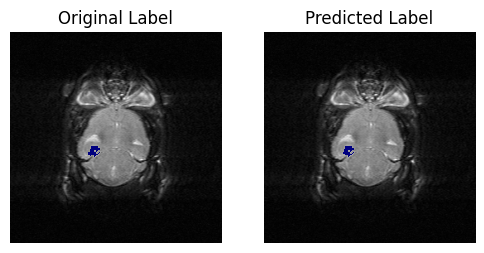

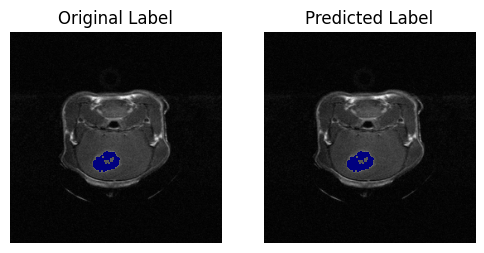

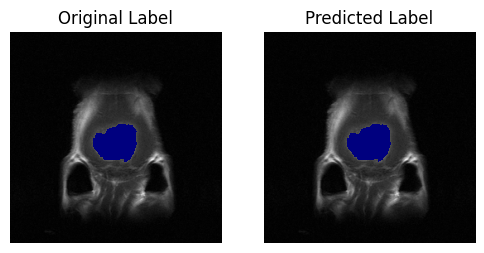

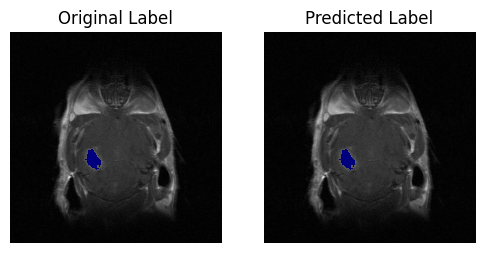

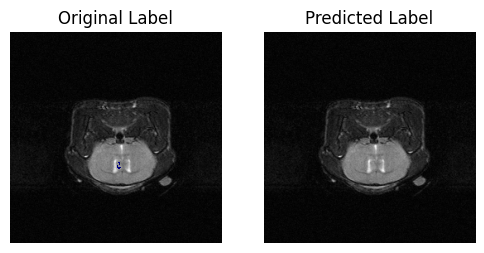

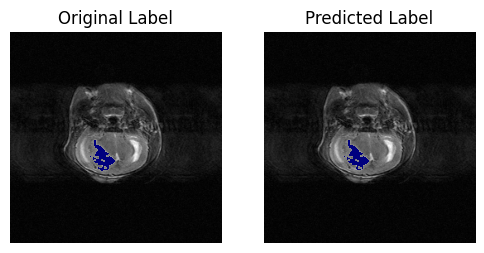

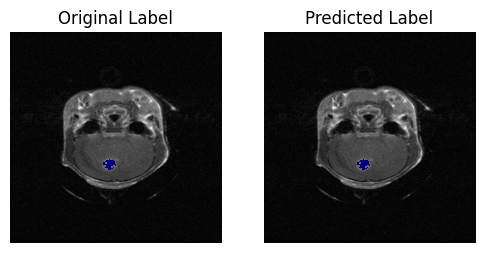

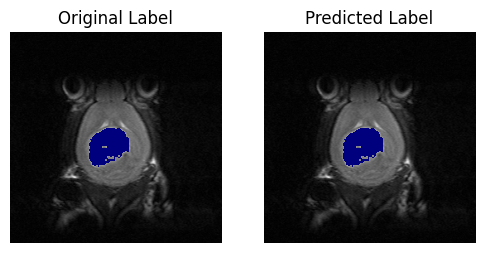

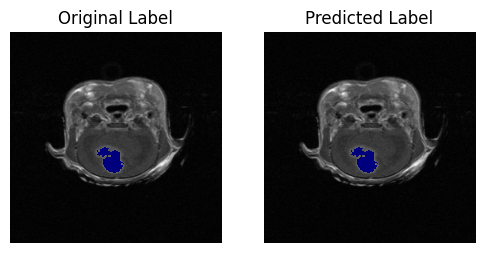

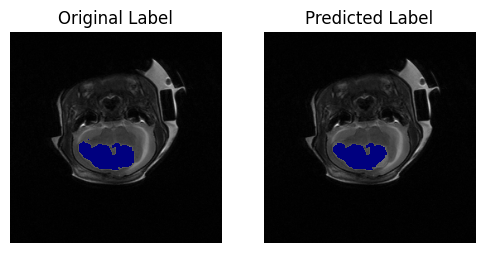

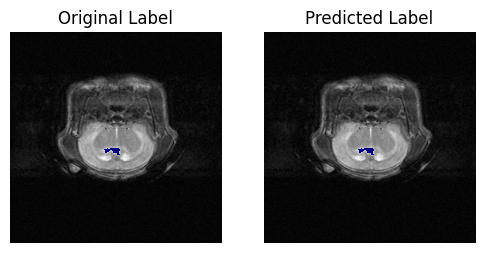

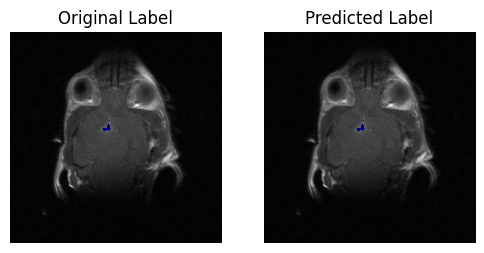

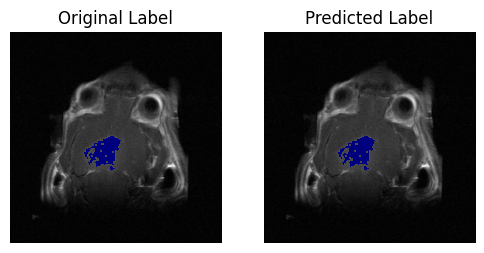

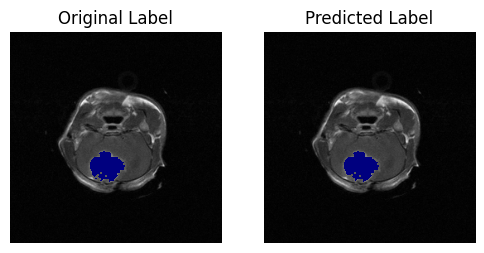

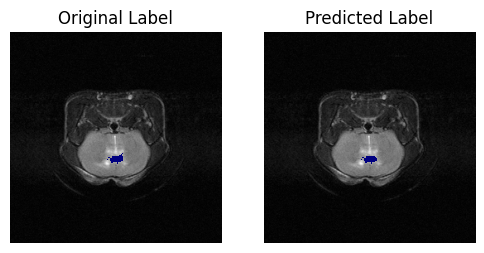

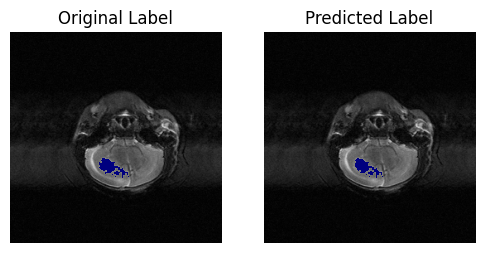

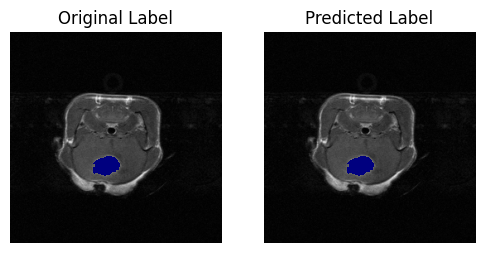

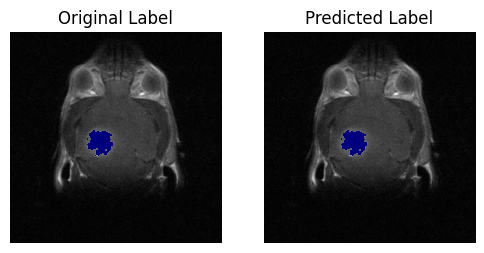

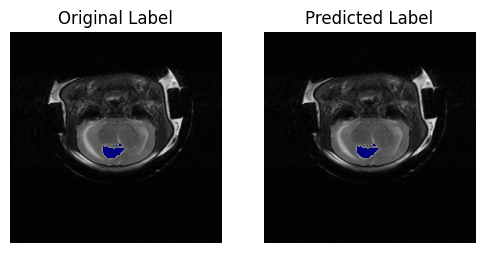

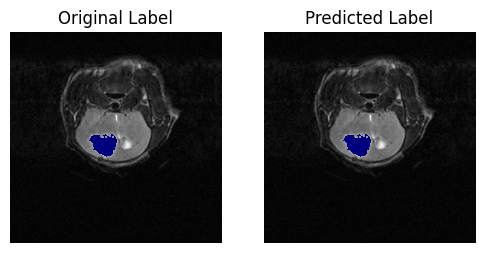

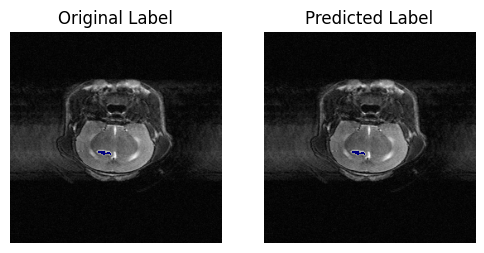

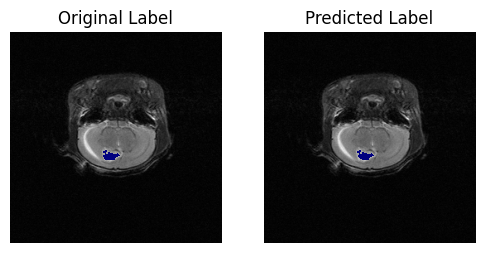

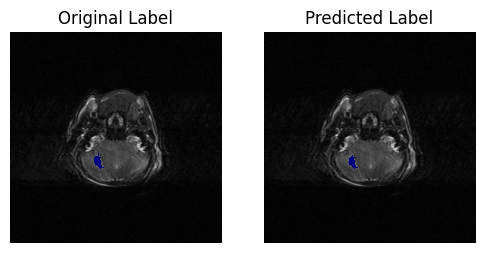

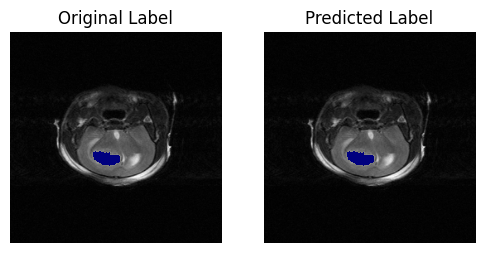

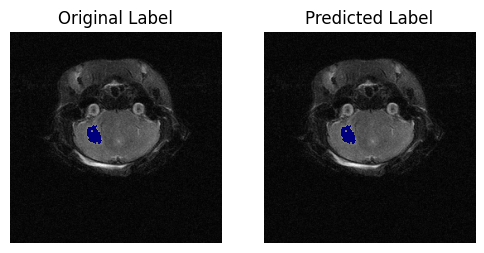

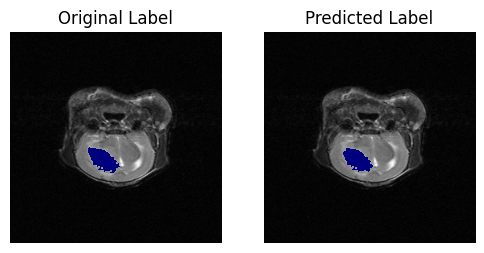

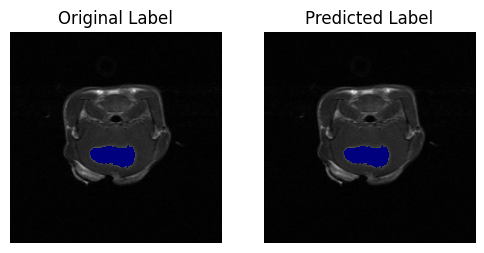

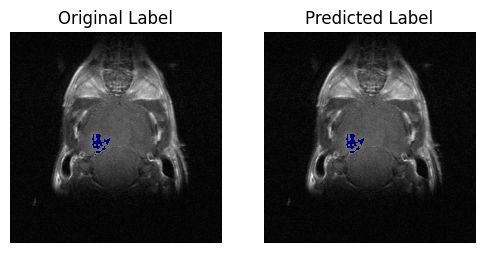

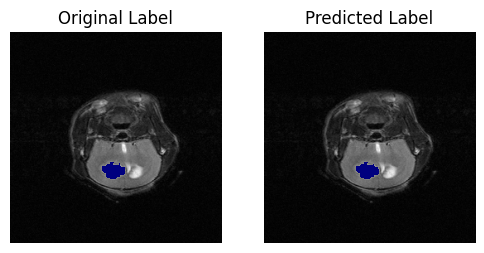

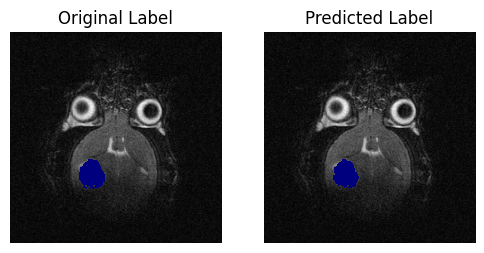

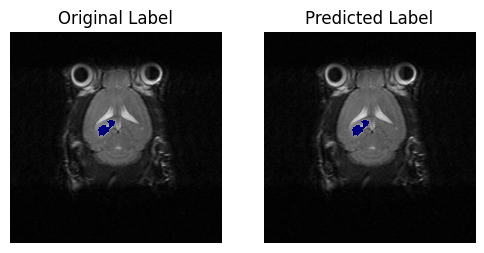

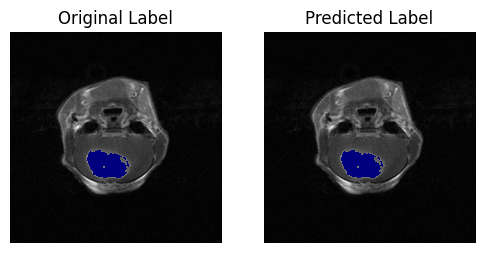

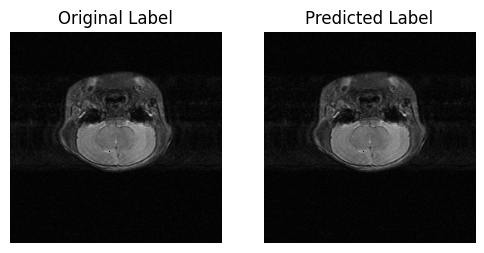

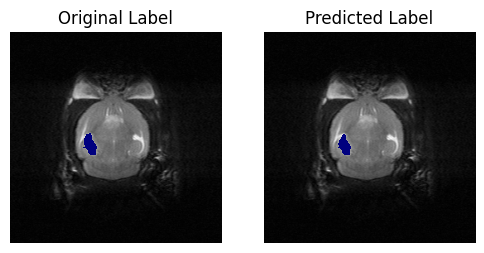

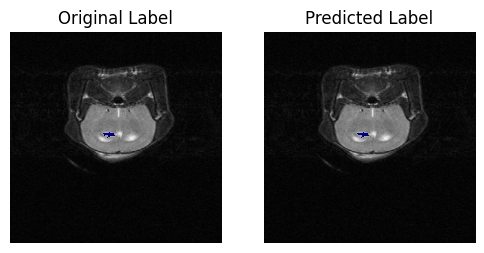

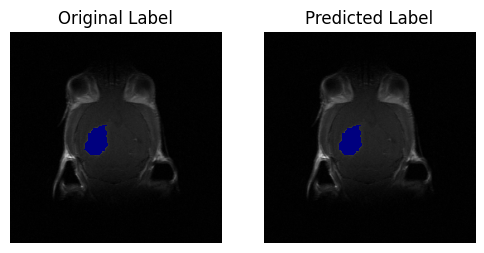

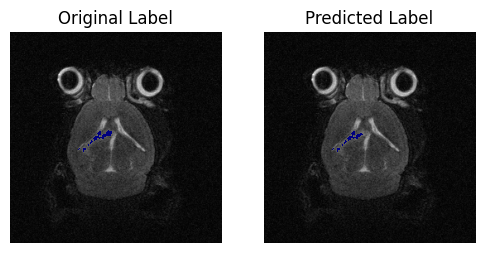

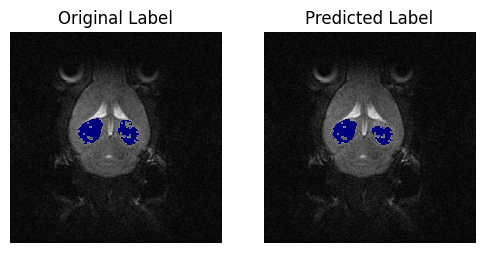

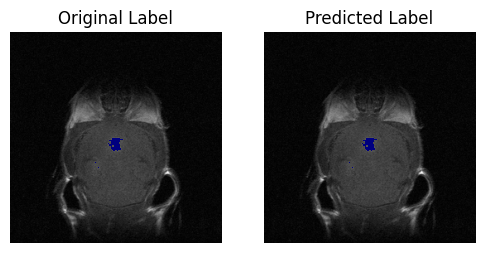

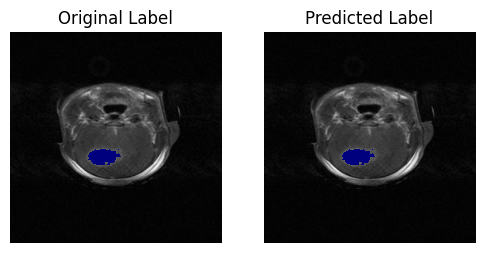

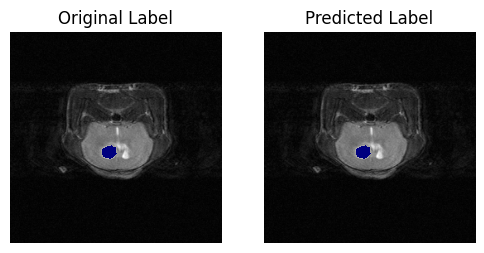

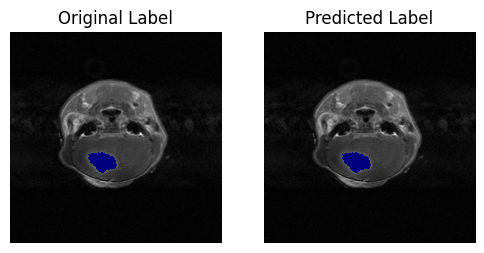

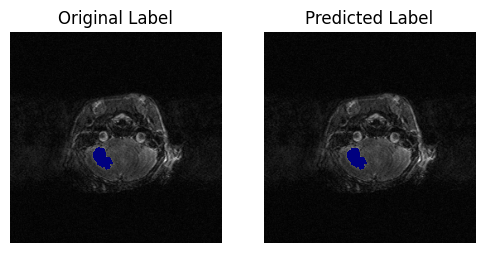

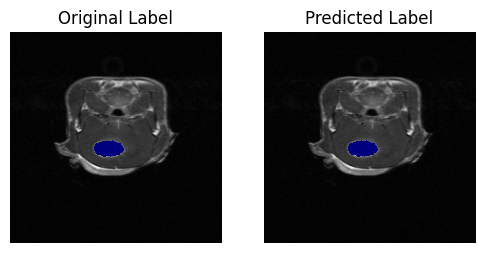

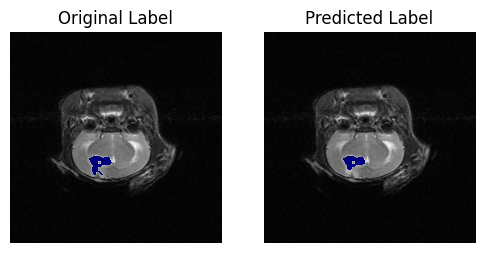

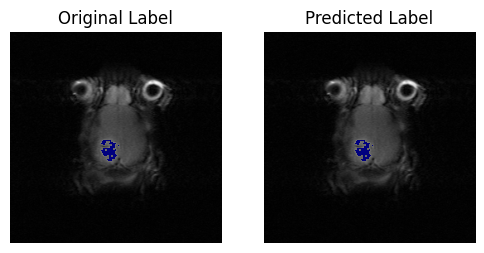

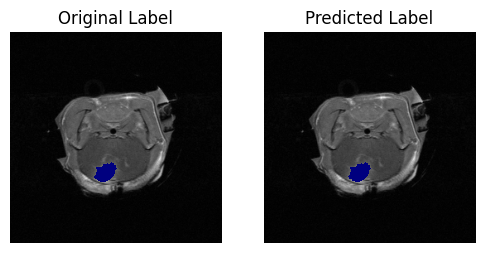

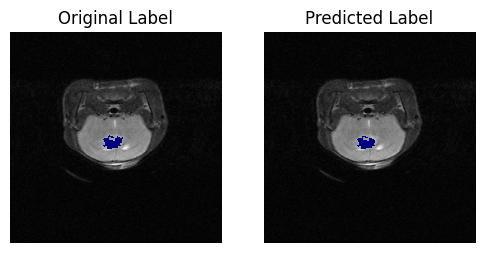

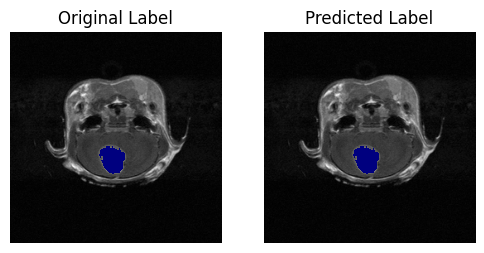

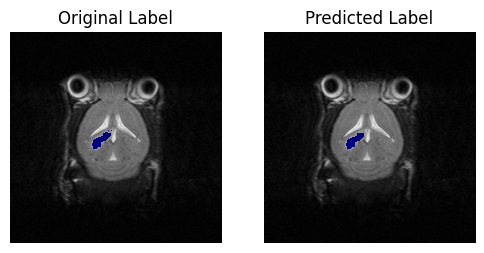

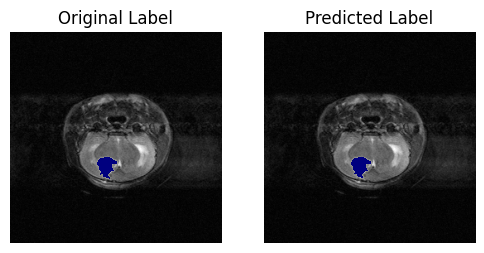

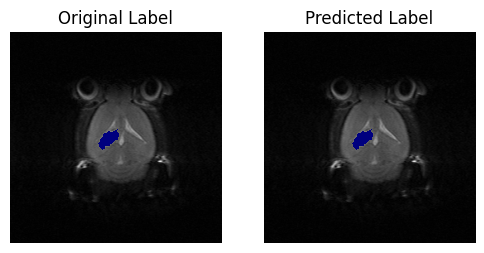

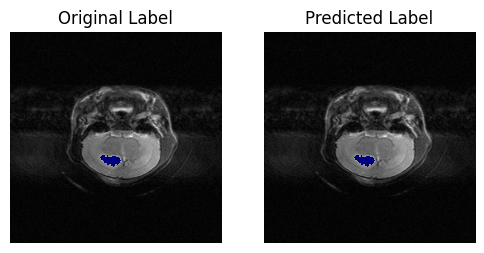

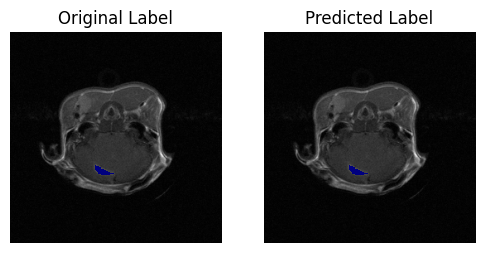

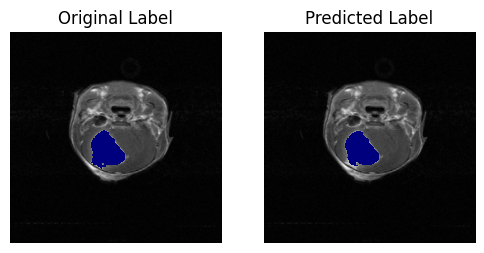

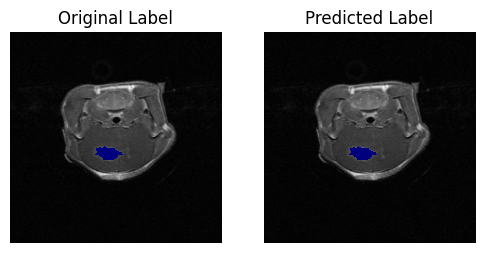

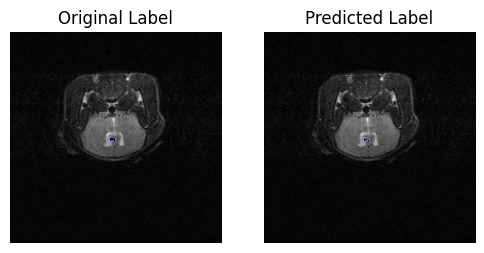

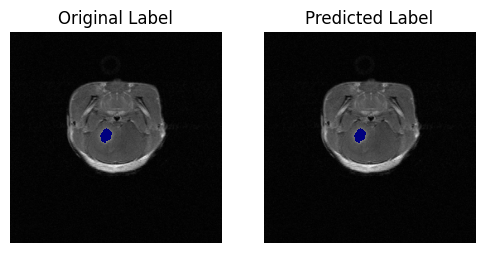

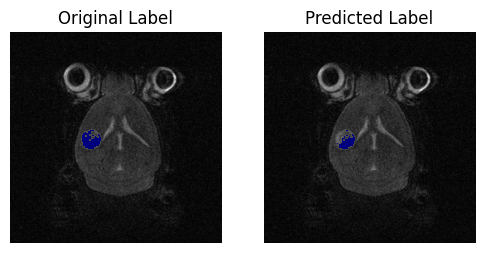

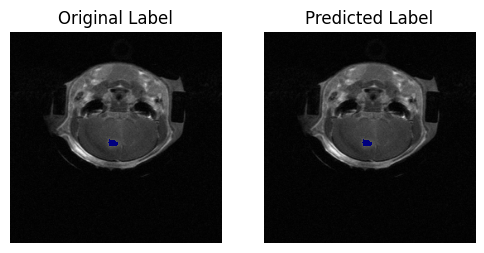

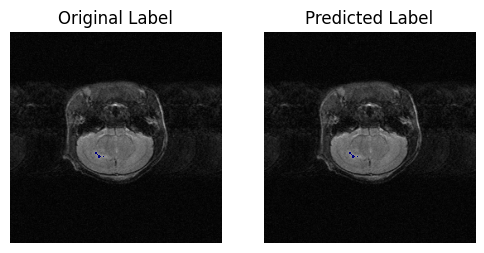

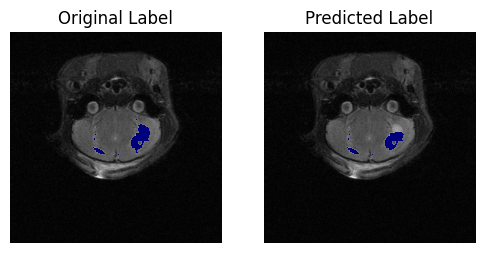

In [15]:
data_params = {
    "height"     : 256,
    "width"      : 256, 
    "n_channels" : 1,
    "batch_size" : 1 
}

hyper_params = {
    "learning_rate" : 1e-5,
    "epochs"        : 100,
    "num_levels"    : 4,
    "batch_norm"    : False,
    "drop_prob"     : 0,
    "lambda"        : 0
}

cb_params = {
    "chk_save_freq"   : 25*1600,
    "estop_min_delta" : 1e-2,
    "estop_patience"  : 5
}

data_dir = "/content/Data/TFR_Data"
save_dir = "/content/Data/archive"

test_model(data_dir,
           save_dir,
           data_params,
           hyper_params,
           cb_params,
           load_weights = True)